In [1]:
# !pip install scikit-learn
# !pip install statsmodels

In [2]:
# 必要なパッケージをインポート
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import japanize_matplotlib
from pathlib import Path
import tqdm

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression


In [3]:
# データ生成時の設定
num_data = 100
w1 = 4
w2 = 1.5
w3 = 2
w12 = 2
np.random.seed(0)

# 説明変数生成
x1 = np.random.uniform(low=-1, high=1, size=num_data)
e_2 = np.random.uniform(low=-1, high=1, size=num_data)
x2 = w12*x1 + e_2
x3 = np.random.uniform(low=-1, high=1, size=num_data)

# 目的変数生成
generator_e = np.random.default_rng(0)
e_y = generator_e.normal(size=num_data)
Y = w1*x1 + w2*x2 + w3*x3 + e_y

In [4]:
e_y.mean()

0.08109669349071558

In [5]:
# データフレーム化
df = pd.DataFrame({'Y': Y,
                   'x1': x1,
                   'x2': x2,
                   'x3' : x3
                   })
df.tail(5)

,Y,x1,x2,x3
95,-4.535223,-0.633617,-1.286317,-0.551366
96,-1.054188,0.173026,-0.199119,-0.804311
97,-6.592188,-0.959785,-2.410857,0.724383
98,3.829706,0.657880,0.431818,0.945839
99,-6.689195,-0.990609,-2.112385,0.921669


In [6]:
df.describe()

,Y,x1,x2,x3
count,100.000000,100.000000,100.000000,100.000000
mean,-0.177016,-0.054412,-0.052661,0.019264
std,4.363002,0.579508,1.251979,0.606401
min,-8.900733,-0.990609,-2.461411,-0.973526
25%,-3.673734,-0.588394,-0.970761,-0.522906
50%,-0.012805,-0.065038,0.126793,0.008710
75%,3.124557,0.368967,0.981142,0.576753
max,8.695552,0.976748,2.364982,0.980678


/Users/ikuma.wakamatsu/kdc-env/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


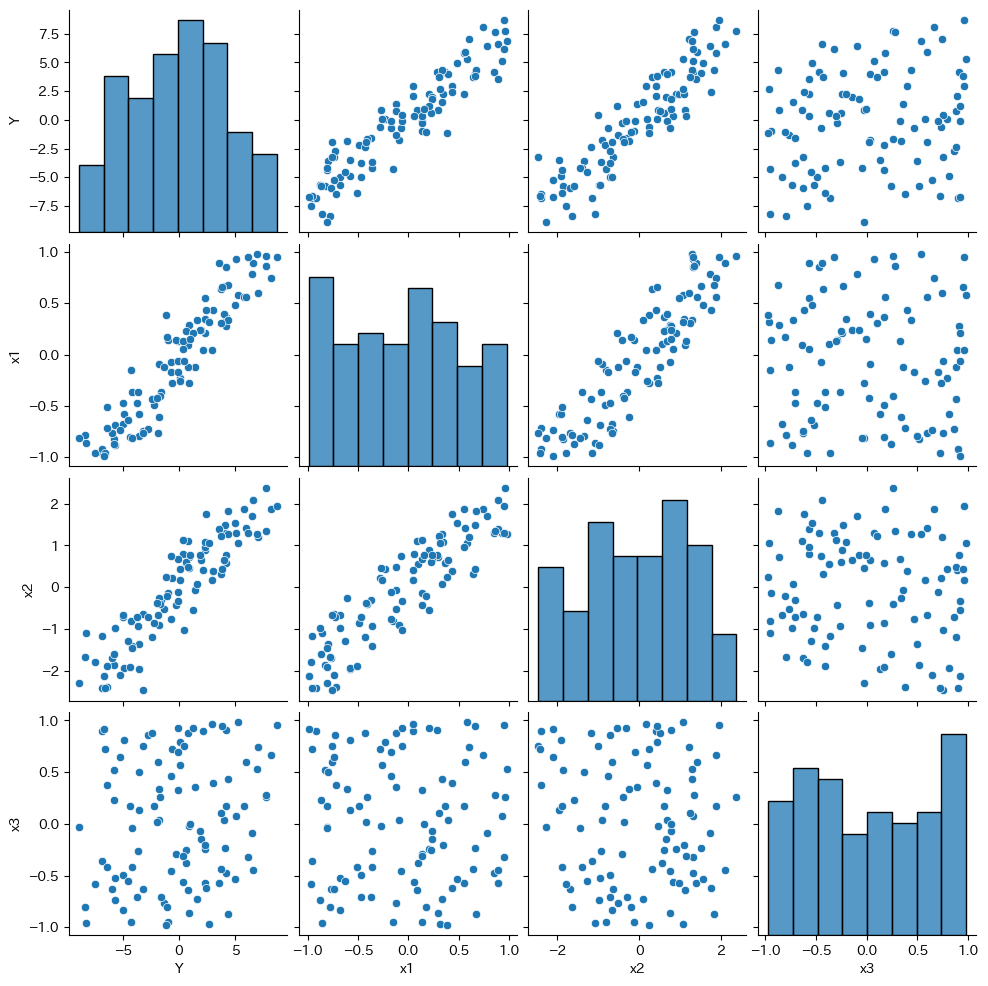

In [7]:
sns.pairplot(df)

In [8]:
# モデリングのために分割
Y = df['Y']
X = df.drop('Y', axis = 1)

In [9]:
# モデリング用の関数定義
def lr_modeling(X, Y, X_col_li):
    # 定数項追加
    X_const = sm.add_constant(X, prepend=False)

    # モデリング
    model = sm.OLS(Y, X_const[X_col_li])
    result = model.fit()

    # 分析結果(偏回帰係数の信頼区間を計算する際の、標準誤差の計算式は要確認)
    print(result.summary())

In [10]:
# 1: 説明変数を全て含めてのモデリングによるパラーメータ推定。
X_col_li =['x1', 'x2', 'x3', 'const']
lr_modeling(X, Y, X_col_li)

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     666.3
Date:                Fri, 17 Nov 2023   Prob (F-statistic):           4.17e-64
Time:                        17:24:26   Log-Likelihood:                -134.56
No. Observations:                 100   AIC:                             277.1
Df Residuals:                      96   BIC:                             287.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             4.1833      0.373     11.219      0.0

In [11]:
# 2: x1の真の効果の推定。中間変数であるx2を除く。x1とx3でモデリングし、パラメータ推定。
# 因果の向き的にはx3も中間変数に位置するが、実務で除ける自信があるかは懸念があるのでとりあえず置いておいく
X_col_li =['x1', 'x3', 'const']
lr_modeling(X, Y, X_col_li)

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     541.6
Date:                Fri, 17 Nov 2023   Prob (F-statistic):           2.34e-53
Time:                        17:24:26   Log-Likelihood:                -163.77
No. Observations:                 100   AIC:                             333.5
Df Residuals:                      97   BIC:                             341.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             7.1033      0.219     32.391      0.0

In [12]:
# 3: 交絡がある状態でx2の推定
X_col_li =['x2', 'const']
lr_modeling(X, Y, X_col_li)

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     480.7
Date:                Fri, 17 Nov 2023   Prob (F-statistic):           1.42e-39
Time:                        17:24:26   Log-Likelihood:                -199.91
No. Observations:                 100   AIC:                             403.8
Df Residuals:                      98   BIC:                             409.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x2             3.1762      0.145     21.926      0.0

In [13]:
# 4: x3のみでパラメータ推定。
X_col_li =['x3', 'const']
lr_modeling(X, Y, X_col_li)

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     2.909
Date:                Fri, 17 Nov 2023   Prob (F-statistic):             0.0912
Time:                        17:24:26   Log-Likelihood:                -287.24
No. Observations:                 100   AIC:                             578.5
Df Residuals:                      98   BIC:                             583.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x3             1.2217      0.716      1.706      0.0